In [44]:
# imports

import itertools
import numpy as np
from scipy import linalg
from sklearn import datasets, mixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import ArtistAnimation
from matplotlib import colors as mcolors
from IPython.display import HTML

In [45]:
# data generator settings

n_samples = 1500
n_features = 2
centers = 4
cluster_std = [np.random.ranf()*3 for i in range(centers)]
center_box = (-10, 10)
shuffle = True
gen_random_state = np.random.randint(0, 9999)

print("cluster_std: ", cluster_std)
print("gen_random_state: ", gen_random_state)

cluster_std:  [2.5647035286712976, 2.6970753536433687, 2.229062866041117, 1.6246540281414008]
gen_random_state:  3046


In [46]:
# example 1: pro EM
'''
# gen
n_samples = 1500
n_features = 2
centers = 5
cluster_std = [0.5653783180481071, 1.183945781909913, 1.337803612031334, 0.8805338293650937, 1.1253370313523166]
center_box = (-10, 10)
shuffle = True
gen_random_state = 367
'''
# example 2: 
n_samples = 1500
n_features = 2
centers = 4
cluster_std = [1.6055544523542218, 0.4764929006599846, 0.8960428456037062, 2.919869572708056]
center_box = (-10, 10)
shuffle = True
gen_random_state = 303

In [47]:
# generate data
data = datasets.make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std, center_box=center_box, shuffle=shuffle, random_state=gen_random_state)

# outlier:
#data[0][0] = [-100, -100]

print("data: ", data)


data:  (array([[ 3.46272918, -0.95405925],
       [ 5.78101587, -5.16655248],
       [ 4.19617273, -3.48629478],
       ...,
       [ 3.26824562, -3.96724097],
       [ 4.04571125, -2.04536087],
       [ 4.93606798, -0.80837425]]), array([2, 0, 2, ..., 0, 0, 0]))


In [48]:
# color helper functions

def color(i):
    #colors = ['navy', 'c', 'cornflowerblue', 'gold', 'darkorange', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange']
    colors = ["#000000","#FF0000","#00FF00","#0000FF","#FFFF00","#00FFFF","#FF00FF","#C0C0C0","#808080","#800000","#808000","#008000","#800080","#008080","#000080"]
    return colors[i]

def colors(Y):
    return [color(i) for i in Y]

Generated Data:


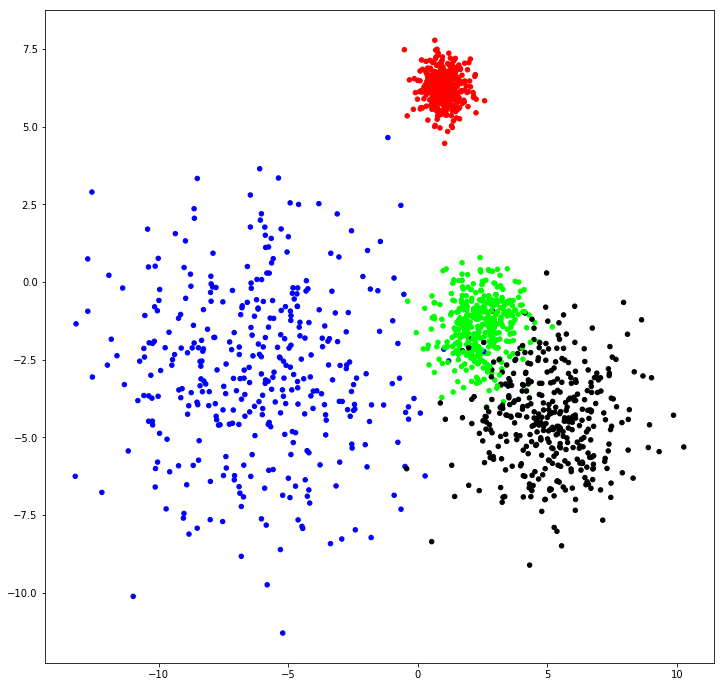

In [49]:
# plot generated data

X = data[0]
c = data[1]

xs = X[:, 0]
ys = X[:, 1]


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(xs, ys, 20, c=colors(c))

print("Generated Data:")
plt.show()

In [50]:
# generate results function
# generates gaussian mixture ellipses and classification

def generate_results(ax, mix):
    Y_ = mix.predict(X)
    means = mix.means_
    covariances = mix.covariances_
    
    # generate scatterplot
    scat = ax.scatter(X[:, 0], X[:, 1], 20, c=[color(i) for i in Y_])
    
    # generate ellipses
    ells = []
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.+angle, color=color(i), animated=True)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ells.append(ell)
        ax.add_patch(ell)
    
    return ells + [scat]
        

In [51]:
# animate results function

# animation settings
interval = 2500

def animate(param, param_gm, param_bgm, X, frame_range):
    
    fig = plt.figure(figsize=(12, 8))

    # GaussianMixture (EM) subplot
    ax_gm = fig.add_subplot(121)
    ax_gm.set_title('Expectation-Maximization')
    # BayesianGaussianMixture (VI) subplot
    ax_bgm = fig.add_subplot(122)
    ax_bgm.set_title('Variational Inference')
    
    artists = []
    for frame in frame_range:

        # results: scatter and ellipses
        # gm
        gm = mixture.GaussianMixture(**param, **param_gm, max_iter=frame).fit(X)
        results_gm = generate_results(ax_gm, gm)
        # bgm
        bgm = mixture.BayesianGaussianMixture(**param, **param_bgm, max_iter=frame).fit(X)
        results_bgm = generate_results(ax_bgm, bgm)
        
        print("Mixing Coefficient ("+str(frame)+"):", bgm.weights_)
        
        # frame counters
        # gm
        counter_gm = ax_gm.text(0.05, 0.95,'',fontsize=16,horizontalalignment='left',verticalalignment='top',transform=ax_gm.transAxes)
        if (gm.converged_):
            counter_gm.set_text(str(gm.n_iter_) + " converged")
        else:
            counter_gm.set_text(frame)
        # bgm
        counter_bgm = ax_bgm.text(0.05, 0.95,'',fontsize=16,horizontalalignment='left',verticalalignment='top',transform=ax_bgm.transAxes)
        if (bgm.converged_):
            counter_bgm.set_text(str(bgm.n_iter_) + " converged")
        else:
            counter_bgm.set_text(frame)
        
        artists.append(results_gm + results_bgm + [counter_gm, counter_bgm])

    
    return ArtistAnimation(fig, artists, interval=interval, blit=True, repeat=False)
    

In [52]:
# ignore sklearn convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category = ConvergenceWarning)

In [53]:
# PARAMETER SETTINGS HERE

# settings for both EM and variational inference
param = {
    'n_components': 5, #4, #8,
    'random_state': 72,
    'init_params': 'random'
}

# settings for EM
param_bm = {
    'tol': 1e-4
}

# settings for variational inference
param_bgm = {
    'tol': 1e-3,
    'weight_concentration_prior': 1e-3, #10,
    'weight_concentration_prior_type': 'dirichlet_distribution'
}

# have many itterations to perform?
frame_range = [1] + list(range(10, 201, 10))


# run
anim = animate(param, param_bm, param_bgm, X, frame_range)

# display animation
plt.close(anim._fig)
HTML(anim.to_jshtml())

Mixing Coefficient (1): [0.24642583 0.24921701 0.25215437 0.2522028 ]
Mixing Coefficient (10): [0.16124497 0.52916538 0.16795837 0.14163128]
Mixing Coefficient (20): [0.11002158 0.36603771 0.18015221 0.3437885 ]
Mixing Coefficient (30): [0.07701012 0.25003276 0.20495517 0.46800195]
Mixing Coefficient (40): [0.06293315 0.25003249 0.22182634 0.46520802]
Mixing Coefficient (50): [0.05854722 0.25003274 0.23457339 0.45684664]
Mixing Coefficient (60): [0.07314777 0.25003721 0.24259177 0.43422325]
Mixing Coefficient (70): [0.12079791 0.25005755 0.24780045 0.38134409]
Mixing Coefficient (80): [0.21278589 0.25005096 0.25168254 0.28548061]
Mixing Coefficient (90): [0.245476   0.25004651 0.25199838 0.2524791 ]
Mixing Coefficient (100): [0.25130588 0.25004613 0.25191303 0.24673496]
Mixing Coefficient (110): [0.25190702 0.25004611 0.25190065 0.24614623]
Mixing Coefficient (120): [0.25190702 0.25004611 0.25190065 0.24614623]
Mixing Coefficient (130): [0.25190702 0.25004611 0.25190065 0.24614623]
Mix

In [54]:
# export animation as gif:
# you may need to install "imagemagick" (ex.: brew install imagemagick)
#anim.save('./animation.gif', writer='imagemagick', fps=0.5)